In [1]:
# Author: Mikita Sazanovich

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
os.chdir(os.path.abspath('..'))

In [21]:
import math
import os

import torch
import torch.nn as nn
from torch import autograd
from torch import distributions
from torch import optim
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import utils as tutils
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import dataset
import dvae.model as dmodel
import utils
import idgan.model as imodel
import idgan.trainer as itrainer

In [6]:
# Change it to cuda if you want to use a GPU.
DEVICE = 'cpu'

In [25]:
# Feature extractor for FID calculation.

from metrics.inception import load_pretrained_inception, InceptionFeatureExtractor
from metrics.calculate_fid import calculate_fid

inception_model = load_pretrained_inception()
inception_feature_extractor = InceptionFeatureExtractor(inception_model)
inception_feature_extractor.eval()
inception_feature_extractor = inception_feature_extractor.to(DEVICE)

In [203]:
name2params = {
  'idgan_dsprites': ('idgan_dsprites.yaml', 'idgan_dsprites', 300000, 8),
  'idgan_cars': ('idgan_cars.yaml', 'idgan_cars', 300000, 8),
  'idgan_chairs': ('idgan_chairs.yaml', 'idgan_chairs', 25000, 8),
  'idgan_celeba': ('idgan_celeba.yaml', 'idgan_celeba', 300000, 8),
  'idgan_celeba_128': ('idgan_celeba_128.yaml', 'idgan_celeba_128', 300000, 6),
  'idgan_celeba_256': ('idgan_celeba_256.yaml', 'idgan_celeba_256', 300000, 4),
}

NAME = 'idgan_celeba_256'

EXP_CONFIG_NAME, TAG, STEP, BATCH_SIZE = name2params[NAME]

In [204]:
args = utils.parse_args([os.path.join('exps', EXP_CONFIG_NAME), 'jupyter'])
config = utils.load_config(args.config_path)
utils.fix_random_seed(args.seed)
config

{'dataset': 'celeba_256',
 'image_size': 256,
 'dvae_checkpoint': 'output/dvae_celeba/checkpoints/model_1000000',
 'c_dim': 20,
 's_dim': 256,
 'gp_param': '1e1',
 'info_alpha': '1e-3',
 'batch_size': 16,
 'max_iter': 300000,
 'optimizer': 'rmsprop',
 'lr_g': '1e-4',
 'lr_d': '1e-4',
 'generator': {'name': 'ResNetGenerator'},
 'discriminator': {'name': 'ResNetDiscriminator'}}

In [205]:
# General.
config['batch_size'] = BATCH_SIZE
device = DEVICE

In [206]:
# Data
dataloader = dataset.get_dataloader(config, num_workers=12, preprocessing_type='idgan')

In [207]:
def denormalize_img(img):
  img = (img + 1.0) / 2
  img = np.transpose(img, (1, 2, 0))
  return img

In [208]:
# Models
c_dim = config['c_dim']
s_dim = config['s_dim']
channels = dataloader.dataset[0].size(0)
dvae = dmodel.BetaVAE_H(c_dim, channels)
dvae.load_state(config['dvae_checkpoint'])
z_dim = c_dim + s_dim
image_size = config['image_size']
generator_cls = imodel.GENERATORS[config['generator']['name']]
generator_kwargs = {'z_dim': z_dim, 'channels': channels, 'image_size': image_size}
generator = generator_cls(**generator_kwargs)
discriminator_cls = imodel.DISCRIMINATORS[config['discriminator']['name']]
discriminator_kwargs = {'channels': channels, 'image_size': image_size}
discriminator = discriminator_cls(**discriminator_kwargs)

dvae.to(device)
generator.to(device)
discriminator.to(device)

generator_ckpt_path = f'output/{TAG}/checkpoints/generator_{STEP}'
generator.load_state(generator_ckpt_path)
print('Restored the generator checkpoint.')
discriminator_ckpt_path = f'output/{TAG}/checkpoints/discriminator_{STEP}'
discriminator.load_state(discriminator_ckpt_path)
print('Restored the discriminator checkpoint.')

Restored the generator checkpoint.
Restored the discriminator checkpoint.


In [209]:
# Latent distributions
c_dist = distributions.Normal(torch.zeros(c_dim).to(device), torch.ones(c_dim).to(device))
s_dist = distributions.Normal(torch.zeros(s_dim).to(device), torch.ones(s_dim).to(device))

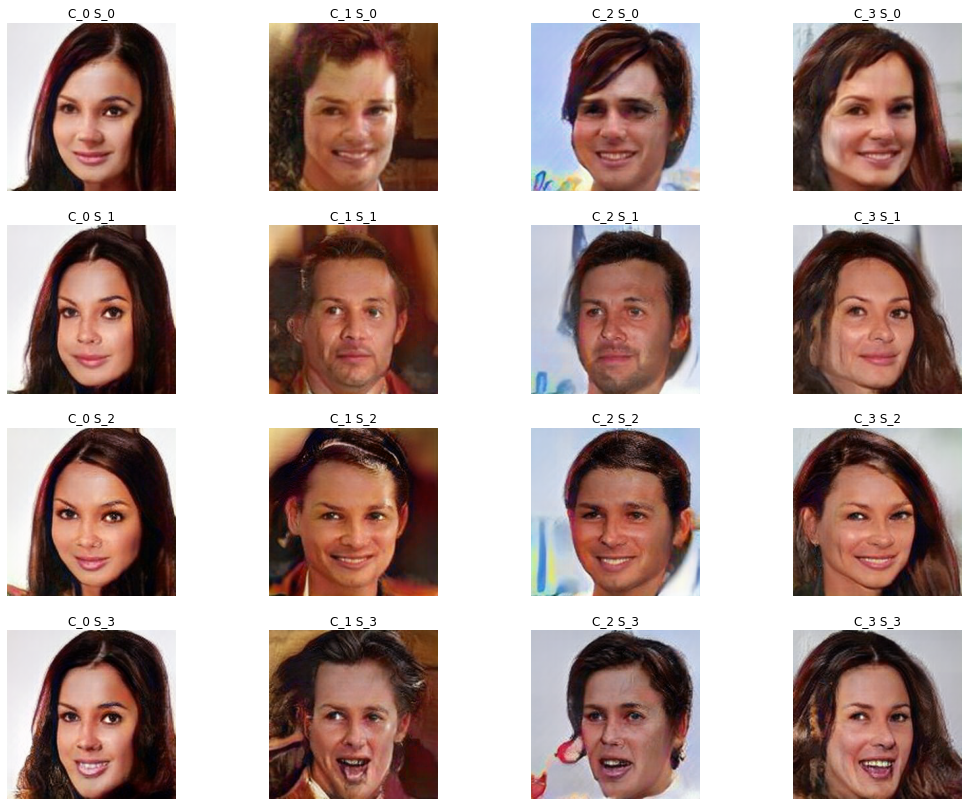

In [210]:
# Figure 8 from the paper.

real_samples = next(iter(dataloader))

cmap = None

with torch.no_grad():
  if (real_samples.size(2) > 64) or (real_samples.size(3) > 64):
    real_samples_resized = F.adaptive_avg_pool2d(real_samples, (64, 64))
  else:
    real_samples_resized = real_samples
  c, c_mu, c_logvar = dvae.encode((real_samples_resized + 1.0) / 2)
  s = s_dist.sample((BATCH_SIZE,))

rows = BATCH_SIZE
columns = BATCH_SIZE
plt.figure(figsize=(18, 18))
img_index = 0
for s_i in range(BATCH_SIZE):
  with torch.no_grad():
    z = torch.cat([s[s_i].repeat(BATCH_SIZE, 1), c], 1)
    x_gen = generator(z)
  for c_i in range(BATCH_SIZE):
    img_index += 1
    plt.subplot(BATCH_SIZE + 1, BATCH_SIZE, img_index)
    plt.imshow(denormalize_img(x_gen[c_i]), cmap=cmap)
    plt.axis('off')
    plt.title(f'C_{c_i} S_{s_i}')
plt.show()

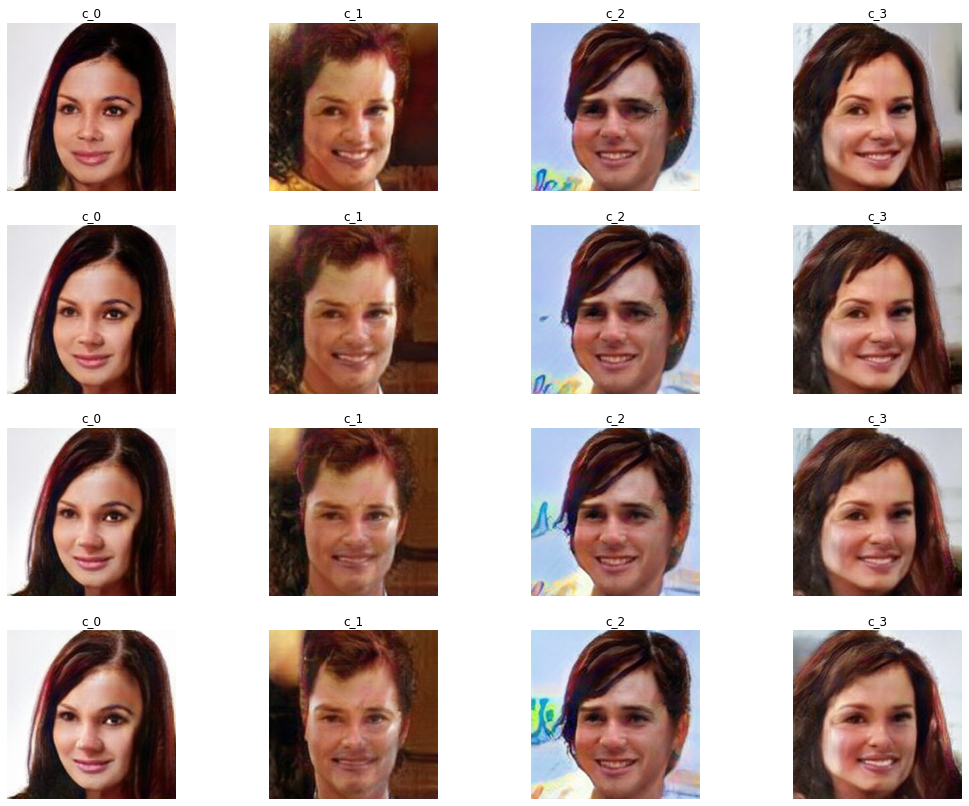

In [211]:
rows = BATCH_SIZE
columns = BATCH_SIZE
plt.figure(figsize=(18, 18))
img_index = 0
# 95% area of the standard normal distribution.
l = -1.96
r = +1.96
c_copy = c.clone()
for row in range(BATCH_SIZE):
  for c_i in range(BATCH_SIZE):
    c_copy[c_i, c_i] = l + (r - l) / (BATCH_SIZE - 1) * row
  s_i = 0
  with torch.no_grad():
    z = torch.cat([s[s_i].repeat(BATCH_SIZE, 1), c_copy], 1)
    x_gen = generator(z)
  for c_i in range(BATCH_SIZE):
    img_index += 1
    plt.subplot(BATCH_SIZE + 1, BATCH_SIZE, img_index)
    plt.imshow(denormalize_img(x_gen[c_i]), cmap=cmap)
    plt.axis('off')
    plt.title(f'c_{c_i}')
plt.show()

In [212]:
class DVAESampler(nn.Module):
  def __init__(self, dvae):
    super().__init__()
    self.dvae = dvae
  
  def sample(self, num_samples):
    z = torch.randn(num_samples, self.dvae.z_dim).to(device)
    samples = self.dvae.decode(z)
    # [0, 1]
    samples = (samples - 0.5) / 0.5
    # [-1.0, 1.0]
    return samples
  
def calculate_vae_fid(dataloader, dvae):
  sampler = DVAESampler(dvae)
  betavae_fid = calculate_fid(dataloader, sampler, inception_feature_extractor)
  print(f'BetaVAE FID = {betavae_fid:.0f}')

In [213]:
class ResNetGeneratorSampler(nn.Module):
  def __init__(self, generator):
    super().__init__()
    self.generator = generator

  def sample(self, num_samples):
    z = torch.randn(num_samples, z_dim).to(device)
    samples = self.generator(z)
    return samples
    
    
def calculate_idgan_fid(dataloader, generator):
  sampler = ResNetGeneratorSampler(generator)
  idgan_fid = calculate_fid(dataloader, sampler, inception_feature_extractor)
  print(f'ResNet-ID-GAN FID = {idgan_fid:.0f}')

In [214]:
calculate_vae_fid(dataloader, dvae)
calculate_idgan_fid(dataloader, generator)